In [45]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [46]:
def load_mel_spectrogram(file_path, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, sr=None)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel = librosa.power_to_db(mel, ref=np.max)

    # Pad or crop to fixed width
    if mel.shape[1] < max_len:
        pad = max_len - mel.shape[1]
        mel = np.pad(mel, ((0,0),(0,pad)), mode="constant")
    else:
        mel = mel[:, :max_len]

    mel = mel.astype(np.float32)
    return mel

In [38]:
X = []
Y = []

for label in classes:
    folder = os.path.join(DATASET_PATH, label)

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            mel = load_mel(path)
            X.append(mel)
            Y.append(label)

X = np.array(X)
Y = np.array(Y)

print("Dataset:", X.shape)
print("Label counts:", {c: sum(Y==c) for c in classes})

Dataset: (610, 128, 128, 1)
Label counts: {'dog': np.int64(210), 'cat': np.int64(207), 'bird': np.int64(193)}


In [47]:
DATASET_PATH = "../data"
classes = ["dog", "cat", "bird"]

X = []
Y = []

for label in classes:
    class_path = os.path.join(DATASET_PATH, label)

    for file in os.listdir(class_path):
        if file.endswith(".wav"):
            file_path = os.path.join(class_path, file)
            mel = load_mel_spectrogram(file_path)
            X.append(mel)
            Y.append(label)

X = np.array(X)
Y = np.array(Y)
print("Dataset shape:", X.shape)

Dataset shape: (610, 128, 128)


In [48]:
le = LabelEncoder()
Y_enc = le.fit_transform(Y)
Y_cat = to_categorical(Y_enc)

X = X[..., np.newaxis]  # Add channel dimension

X_train, X_test, y_train, y_test = train_test_split(
    X, Y_cat, test_size=0.2, random_state=42, shuffle=True
)

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Reshape, Bidirectional, LSTM, Dense, Dropout, Flatten

input_layer = Input(shape=(128, 128, 1))

# -------------------------
# CNN Feature Extractor
# -------------------------
x = Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

# Shape becomes (freq=16, time=16, channels=128)
# We convert it into a sequence for RNN:
x = Reshape((16, 16 * 128))(x)

# -------------------------
# RNN (Bi-LSTM)
# -------------------------
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.3)(x)

# -------------------------
# Dense Classifier
# -------------------------
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,323,587 (8.86 MB)

 Trainable params: 2,323,139 (8.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [50]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.4385 - loss: 1.0606 - val_accuracy: 0.3443 - val_loss: 1.1064
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.6209 - loss: 0.8065 - val_accuracy: 0.4508 - val_loss: 1.1136
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.6947 - loss: 0.7122 - val_accuracy: 0.3443 - val_loss: 1.0799
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7377 - loss: 0.6372 - val_accuracy: 0.5410 - val_loss: 1.0300
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.7930 - loss: 0.5460 - val_accuracy: 0.5656 - val_loss: 1.0023
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.7684 - loss: 0.5474 - val_accuracy: 0.5738 - val_loss: 0.9288
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7930 - loss: 0.4944 - val_accuracy: 0.5738 - val_loss: 0.8659
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.8156 - loss: 0.4539 - val_accuracy: 0.

In [51]:
train_acc = history.history["accuracy"][-1] * 100
val_acc = history.history["val_accuracy"][-1] * 100

print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Validation Accuracy: {val_acc:.2f}%")

Final Training Accuracy: 89.75%
Final Validation Accuracy: 61.48%


In [52]:
def predict_audio(file_path):
    mel = load_mel_spectrogram(file_path)
    mel = np.expand_dims(mel, axis=(0,3))  # (1,128,128,1)
    pred = model.predict(mel)
    idx = np.argmax(pred)
    return le.classes_[idx], pred[0][idx]

In [53]:
import numpy as np

wrong_predictions = []

for i in range(len(X_test)):
    mel = X_test[i]                       # shape (128,128,1)
    true_label = le.classes_[np.argmax(y_test[i])]

    # Prepare mel input
    mel_input = np.expand_dims(mel, axis=0)

    # Predict
    pred = model.predict(mel_input, verbose=0)
    pred_idx = np.argmax(pred)
    pred_label = le.classes_[pred_idx]
    confidence = pred[0][pred_idx]

    # Log ONLY wrong predictions
    if pred_label != true_label:
        wrong_predictions.append({
            "index": i,
            "true": true_label,
            "pred": pred_label,
            "confidence": float(confidence)
        })

In [54]:
print("Wrong Predictions:")
for item in wrong_predictions:
    print(
        f"Sample {item['index']} | True: {item['true']} | "
        f"Predicted: {item['pred']} | Confidence: {item['confidence']:.2f}"
    )

Wrong Predictions:
Sample 0 | True: dog | Predicted: cat | Confidence: 0.50
Sample 2 | True: dog | Predicted: cat | Confidence: 0.50
Sample 3 | True: bird | Predicted: dog | Confidence: 0.72
Sample 4 | True: cat | Predicted: dog | Confidence: 0.57
Sample 6 | True: bird | Predicted: cat | Confidence: 0.80
Sample 8 | True: bird | Predicted: dog | Confidence: 0.75
Sample 9 | True: cat | Predicted: dog | Confidence: 0.51
Sample 12 | True: dog | Predicted: cat | Confidence: 0.57
Sample 16 | True: bird | Predicted: dog | Confidence: 0.74
Sample 17 | True: bird | Predicted: dog | Confidence: 0.60
Sample 20 | True: dog | Predicted: cat | Confidence: 0.42
Sample 21 | True: cat | Predicted: dog | Confidence: 0.82
Sample 22 | True: bird | Predicted: dog | Confidence: 0.53
Sample 26 | True: bird | Predicted: dog | Confidence: 0.65
Sample 28 | True: cat | Predicted: dog | Confidence: 0.46
Sample 31 | True: cat | Predicted: dog | Confidence: 0.45
Sample 33 | True: cat | Predicted: dog | Confidence: 

In [55]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


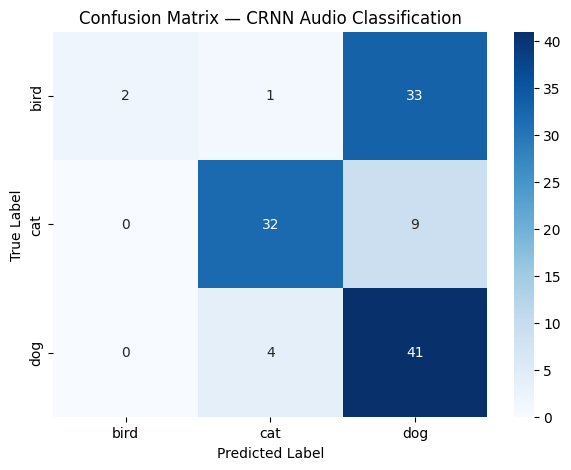

In [59]:
# ---------------------------------------------
# 1. Generate predictions for test set
# ---------------------------------------------
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# ---------------------------------------------
# 2. Build and plot confusion matrix
# ---------------------------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
class_names = le.classes_

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — CRNN Audio Classification")
plt.show()